In [21]:
#downloading the data of google stock for 2 years using yfinance
import yfinance as yf
data = yf.download("GOOGL", start="2021-01-01", end="2025-12-20")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL     GOOGL
Date                                                            
2021-01-04  85.659279  87.463639  84.716898  87.340076  37324000
2021-01-05  86.350060  86.686514  85.201239  85.607668  20360000
2021-01-06  85.498001  86.544598  84.169045  84.375486  46588000
2021-01-07  88.051712  88.224403  85.690547  85.690547  41936000
2021-01-08  89.217400  89.293326  87.400621  88.191649  35484000


In [22]:
# Targetting close price for LSTM model as it is less noisy compare to High/Low
series=data["Close"]["GOOGL"]
print(series.head(15))
#Preprocessing
#1 check if all the values are numeric--->done as dtype is float
print(series.dtype)

Date
2021-01-04    85.659279
2021-01-05    86.350060
2021-01-06    85.498001
2021-01-07    88.051712
2021-01-08    89.217400
2021-01-11    87.155975
2021-01-12    86.220039
2021-01-13    86.707367
2021-01-14    85.896980
2021-01-15    85.733231
2021-01-19    88.554405
2021-01-20    93.298569
2021-01-21    93.501030
2021-01-22    93.918373
2021-01-25    94.003723
Name: GOOGL, dtype: float64
float64


In [23]:
#2 fixing regularity ie deal with the missing value of  saturdays and sundays
series=series.asfreq("B")
series=series.ffill()#fowrward filling as close prices won't change on saturday and sundays
series.index.inferred_freq
print(series.head(15))


Date
2021-01-04    85.659279
2021-01-05    86.350060
2021-01-06    85.498001
2021-01-07    88.051712
2021-01-08    89.217400
2021-01-11    87.155975
2021-01-12    86.220039
2021-01-13    86.707367
2021-01-14    85.896980
2021-01-15    85.733231
2021-01-18    85.733231
2021-01-19    88.554405
2021-01-20    93.298569
2021-01-21    93.501030
2021-01-22    93.918373
Freq: B, Name: GOOGL, dtype: float64


In [24]:
#3 log transforming the series data as close price are non stationary and exponential like
#This makes it easier for out LSTM to learn the data
import numpy as np
series_log = np.log(series)
print(series_log.head(15))

Date
2021-01-04    4.450378
2021-01-05    4.458409
2021-01-06    4.448493
2021-01-07    4.477924
2021-01-08    4.491076
2021-01-11    4.467699
2021-01-12    4.456903
2021-01-13    4.462539
2021-01-14    4.453149
2021-01-15    4.451241
2021-01-18    4.451241
2021-01-19    4.483617
2021-01-20    4.535805
2021-01-21    4.537972
2021-01-22    4.542426
Freq: B, Name: GOOGL, dtype: float64


In [25]:
#4 splitting the data in train and test data
#This splitting is done manually so that out time series data doesn't get shuffled
train_size = int(len(series_log) * 0.8)
train = series_log[:train_size]
test  = series_log[train_size:]

In [26]:
#5 Scaling the data so that LSTM is well-trained
#LSTM is scale sensitive
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled  = scaler.transform(test.values.reshape(-1,1))

In [27]:
#ploting train-test data
print("Total samples:", len(series))
print("Train samples:", len(train))
print("Test samples:", len(test))

print("\nTrain period:")
print(train.index.min(), "→", train.index.max())

print("\nTest period:")
print(test.index.min(), "→", test.index.max())

Total samples: 1295
Train samples: 1036
Test samples: 259

Train period:
2021-01-04 00:00:00 → 2024-12-23 00:00:00

Test period:
2024-12-24 00:00:00 → 2025-12-19 00:00:00


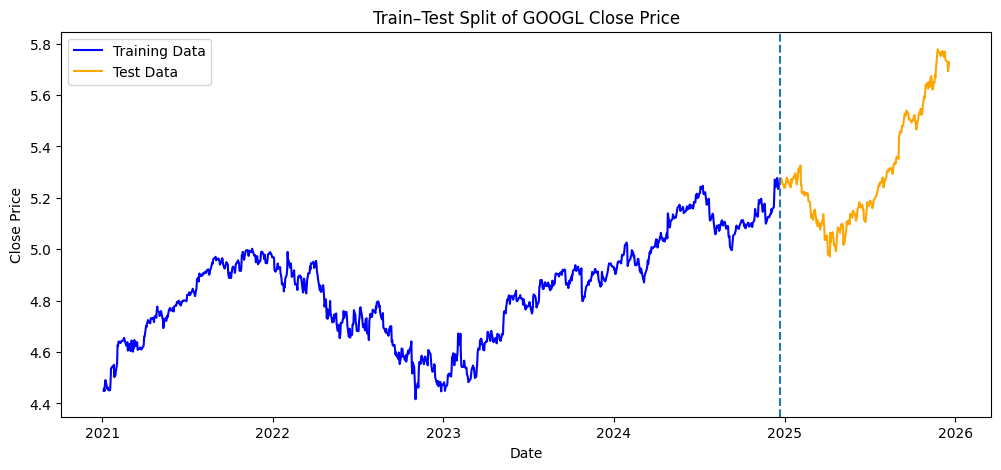

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Training Data", color="blue")
plt.plot(test.index, test, label="Test Data", color="orange")

plt.axvline(train.index[-1], linestyle="--")  # split marker
plt.title("Train–Test Split of GOOGL Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [29]:
 #6 Creating the sliding window
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 60  # 60 trading days ≈ 3 months
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test   = create_dataset(test_scaled, look_back)

#reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [30]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.Sequential)

2.19.0
<class 'keras.src.models.sequential.Sequential'>


In [31]:
#Developing LSTM model

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

Sequential = tf.keras.Sequential
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

look_back=60

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)


C:\Users\prana\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
#Training data using validation split( no shuffle)
#add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0769 - val_loss: 0.0024
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0171 - val_loss: 0.0080
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0103 - val_loss: 0.0040
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - val_loss: 0.0022
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - val_loss: 0.0024
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - val_loss: 0.0026
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

In [33]:
#Predictions are scaled & logged — reversing both.
pred_scaled = model.predict(X_test)

pred = scaler.inverse_transform(pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

pred = np.exp(pred)
y_test_inv = np.exp(y_test_inv)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [34]:
#calculating errors
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, pred))
print("RMSE:", rmse)
mae = mean_absolute_error(y_test_inv, pred)
print("MAE:", mae)
mape = np.mean(np.abs((y_test_inv - pred) / y_test_inv)) * 100
print("MAPE:", mape, "%")

RMSE: 16.801669211194163
MAE: 12.3312594926537
MAPE: 5.063544358977255 %


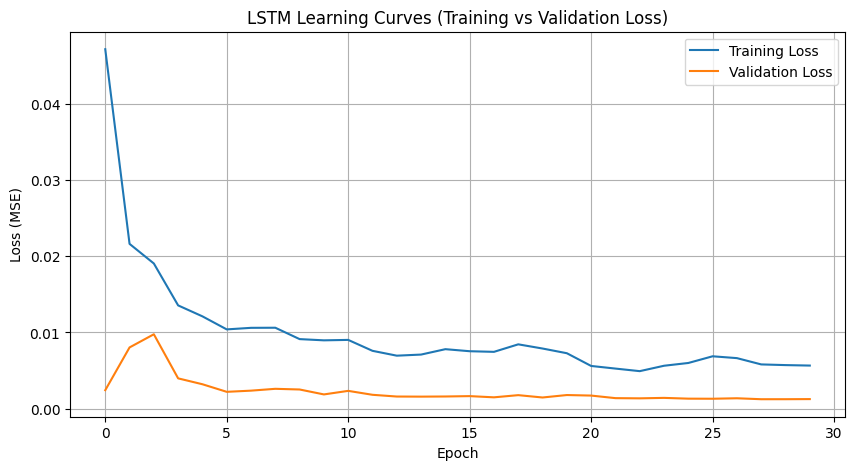

In [35]:
#Learning curves for the LSTM model (training vs. validation loss)
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('LSTM Learning Curves (Training vs Validation Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


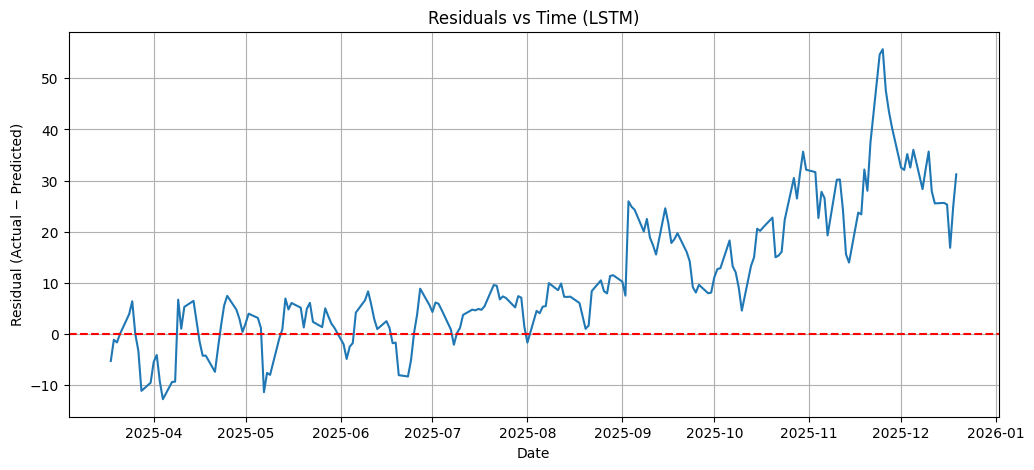

In [37]:
#Residual plots for both LSTM model
residuals = y_test_inv.flatten() - pred.flatten()

plt.figure(figsize=(12, 5))
plt.plot(test.index[-len(residuals):], residuals)
plt.axhline(0, color='red', linestyle='--')

plt.title("Residuals vs Time (LSTM)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual − Predicted)")
plt.grid(True)
plt.show()